In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset without Target Variables
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


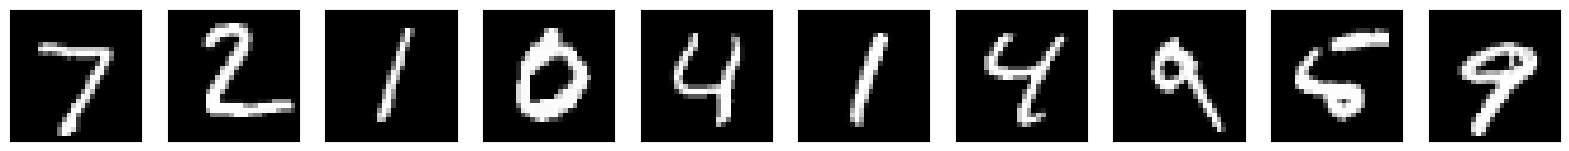

In [3]:
# Display the Loaded dataset sample images


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28*28*1))
x_test = x_test.reshape((len(x_test), 28*28*1))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

In [6]:
input_layer_cnv = Input(shape = (28,28,1))
ae_cnv_en = Conv2D (32, (3,3), activation = "relu", padding = "same", kernel_initializer="he_normal")(input_layer_cnv)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Conv2D (32, (3,3), activation = "relu", padding = "same")(ae_cnv_en)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Conv2D (4, (3,3), activation = "relu", padding = "same")(ae_cnv_en)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Flatten(name = "bot")(ae_cnv_en)

ae_cnv_de = Reshape((4,4,4), input_shape= (64,), name= "botnext0")(ae_cnv_en)
ae_cnv_de = Conv2D (4, (3,3), activation = "relu", padding = "same",name= "botnext1")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2),name= "botnext2")(ae_cnv_de)

ae_cnv_de = Conv2D (32, (3,3), activation = "relu", padding = "same", name= "botnext3")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2), name= "botnext4")(ae_cnv_de)

ae_cnv_de = Conv2D (32, (3,3), activation = "relu", padding = "valid",name= "botnext5")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2), name= "botnext6")(ae_cnv_de)

ae_cnv_de = Conv2D (1, (3,3), activation = "sigmoid", padding = "same",name = "botnext7")(ae_cnv_de)
Ae_Conv = Model(inputs = input_layer_cnv, outputs = ae_cnv_de)

Ae_Conv.compile(optimizer=tf.keras.optimizers.SGD(0.09,clipvalue=2.5), loss='binary_crossentropy', metrics = ["accuracy"])
# Ae_Conv.compile(optimizer=tf.keras.optimizers.Adadelta(0.1,clipvalue=2), loss='binary_crossentropy', metrics = ["accuracy"])
Ae_Conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 4)           1156  

In [7]:
ae_conv_encoder = Model (inputs = input_layer_cnv, outputs = Ae_Conv.get_layer("bot").output, name = "Conv_AE_encoder")
ae_conv_encoder.summary()

Model: "Conv_AE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 4)       

In [8]:
# Traversing through the Layers of Decoder using Loop

encode_inp_cnv = Input(shape = (64,))
tmp_dec = Ae_Conv.get_layer("botnext0")(encode_inp_cnv)
for i in range(1,8):
  st = "botnext{}".format(i)
  tmp_dec = Ae_Conv.get_layer(st)(tmp_dec)

ae_conv_decoder = Model(inputs = encode_inp_cnv, outputs = tmp_dec, name= "Conv_AE_decoder")
ae_conv_decoder.summary()



Model: "Conv_AE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 botnext0 (Reshape)          (None, 4, 4, 4)           0         
                                                                 
 botnext1 (Conv2D)           (None, 4, 4, 4)           148       
                                                                 
 botnext2 (UpSampling2D)     (None, 8, 8, 4)           0         
                                                                 
 botnext3 (Conv2D)           (None, 8, 8, 32)          1184      
                                                                 
 botnext4 (UpSampling2D)     (None, 16, 16, 32)        0         
                                                                 
 botnext5 (Conv2D)           (None, 14, 14, 32)    

In [9]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [10]:
from time import time
tic = time()
Ae_Conv.fit(x_train, x_train,
                epochs=100,
                verbose=2,
                batch_size=1024,
                shuffle=False, validation_split = 0.1)
                #validation_data=(x_test, x_test))
toc = time()
print("Training Took {} Secs".format(toc-tic))

Epoch 1/100
53/53 - 11s - loss: 0.3424 - accuracy: 0.7874 - val_loss: 0.2401 - val_accuracy: 0.8030 - 11s/epoch - 213ms/step
Epoch 2/100
53/53 - 2s - loss: 0.2299 - accuracy: 0.7870 - val_loss: 0.2183 - val_accuracy: 0.7999 - 2s/epoch - 31ms/step
Epoch 3/100
53/53 - 2s - loss: 0.2163 - accuracy: 0.7875 - val_loss: 0.2114 - val_accuracy: 0.8042 - 2s/epoch - 29ms/step
Epoch 4/100
53/53 - 2s - loss: 0.2074 - accuracy: 0.7894 - val_loss: 0.2000 - val_accuracy: 0.7925 - 2s/epoch - 31ms/step
Epoch 5/100
53/53 - 2s - loss: 0.2008 - accuracy: 0.7900 - val_loss: 0.1923 - val_accuracy: 0.7945 - 2s/epoch - 32ms/step
Epoch 6/100
53/53 - 2s - loss: 0.1986 - accuracy: 0.7902 - val_loss: 0.1969 - val_accuracy: 0.8034 - 2s/epoch - 30ms/step
Epoch 7/100
53/53 - 2s - loss: 0.1915 - accuracy: 0.7917 - val_loss: 0.2135 - val_accuracy: 0.8067 - 2s/epoch - 29ms/step
Epoch 8/100
53/53 - 2s - loss: 0.1903 - accuracy: 0.7921 - val_loss: 0.2074 - val_accuracy: 0.8069 - 2s/epoch - 29ms/step
Epoch 9/100
53/53 - 2

In [11]:
encoded_imgs = ae_conv_encoder.predict(x_test)
#encoded_imgs = ae_conv_encoder.predict(x_train[0:100])
print (encoded_imgs.shape)

313/313 [==============================] - 1s 3ms/step
(10000, 64)


313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 64)


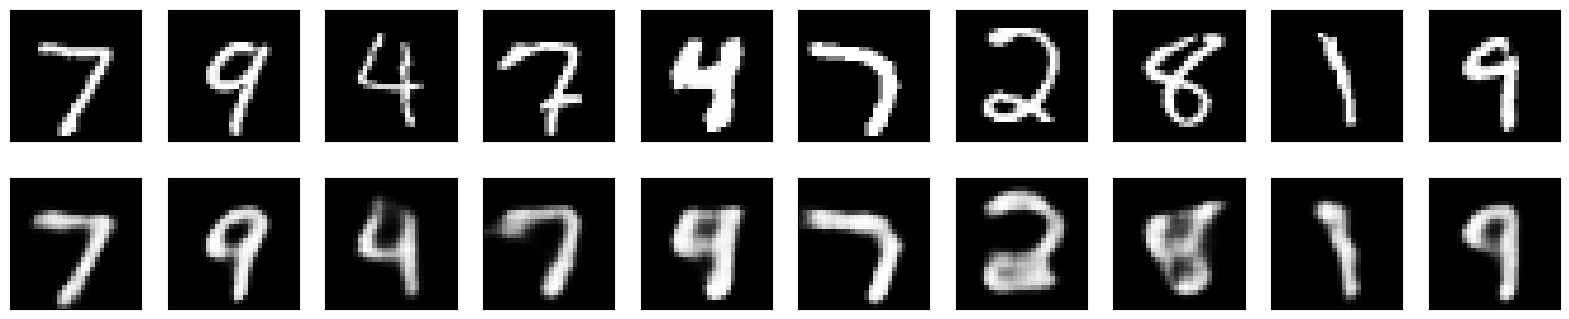

In [12]:
#decoded_imgs = ae_conv_decoder.predict(encoded_imgs)
decoded_imgs = ae_conv_decoder.predict(encoded_imgs)

deoceded_images = Ae_Conv.predict(x_test)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (decoded_imgs.shape,
                                                                                                                      encoded_imgs.shape))
n = 10  # how many digits we will display
k= 12 # multiplier
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 28, 28, 1)


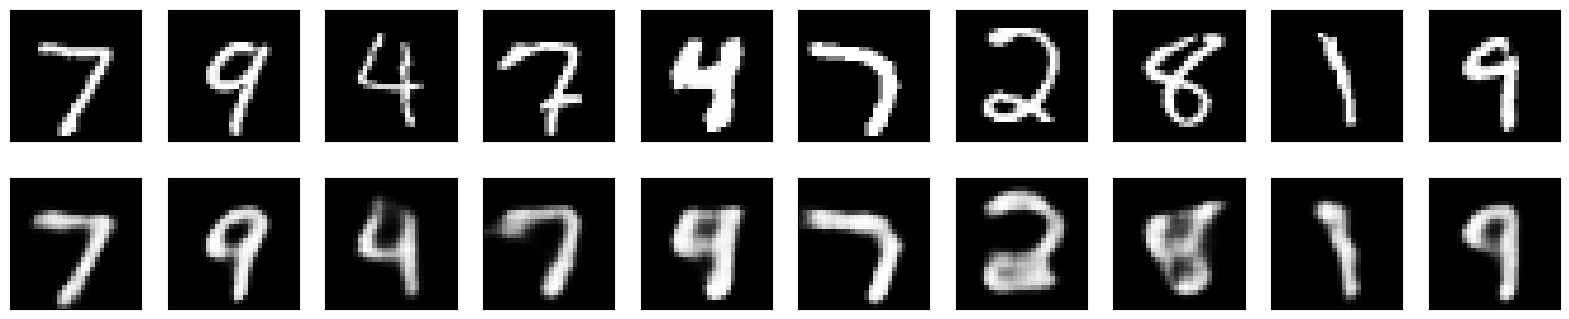

In [13]:
deoceded_images = Ae_Conv.predict(x_test)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (deoceded_images.shape,
                                                                                                                      deoceded_images.shape))
n = 10  # how many digits we will display
k= 12 # multiplier
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(deoceded_images[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [15]:
# Create Noisy Data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape,x_test_noisy.shape )

(60000, 28, 28, 1) (10000, 28, 28, 1)


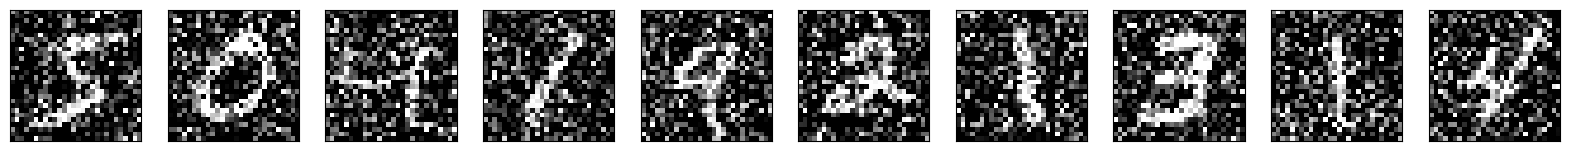

In [16]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [17]:
input_layer_cnv = Input(shape = (28,28,1))
ae_cnv_en = Conv2D (32, (3,3), activation = "relu", padding = "same", kernel_initializer="he_normal")(input_layer_cnv)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Conv2D (32, (3,3), activation = "relu", padding = "same")(ae_cnv_en)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Conv2D (4, (3,3), activation = "relu", padding = "same")(ae_cnv_en)
ae_cnv_en = MaxPooling2D ((2,2), padding="same")(ae_cnv_en)

ae_cnv_en = Flatten(name = "bot")(ae_cnv_en)

ae_cnv_de = Reshape((4,4,4), input_shape= (64,), name= "botnext0")(ae_cnv_en)

ae_cnv_de = Conv2D (4, (3,3), activation = "relu", padding = "same",name= "botnext1")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2),name= "botnext2")(ae_cnv_de)

ae_cnv_de = Conv2D (32, (3,3), activation = "relu", padding = "same", name= "botnext3")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2), name= "botnext4")(ae_cnv_de)

ae_cnv_de = Conv2D (32, (3,3), activation = "relu", padding = "valid",name= "botnext5")(ae_cnv_de)
ae_cnv_de = UpSampling2D ((2,2), name= "botnext6")(ae_cnv_de)

ae_cnv_de = Conv2D (1, (3,3), activation = "sigmoid", padding = "same",name = "botnext7")(ae_cnv_de)
Ae_Conv_denoise = Model (inputs = input_layer_cnv, outputs = ae_cnv_de)

#Ae_Conv.compile(optimizer=tf.keras.optimizers.SGD(0.09,clipvalue=2.5), loss='binary_crossentropy', metrics = ["accuracy"])

Ae_Conv_denoise.compile(optimizer=tf.keras.optimizers.Adadelta(0.1,clipvalue=2), loss='binary_crossentropy', metrics = ["accuracy"])
Ae_Conv_denoise.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 4)           1156

In [18]:
ae_conv_dns_encoder = Model (inputs = input_layer_cnv,outputs = Ae_Conv_denoise.get_layer("bot").output, name = "Conv_AE_dns_encoder")
ae_conv_dns_encoder.summary()

Model: "Conv_AE_dns_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 4)   

In [19]:
encode_inp_cnv = Input(shape = (64,))
tmp_dec = Ae_Conv_denoise.get_layer("botnext0")(encode_inp_cnv)
for i in range(1,8):
  st = "botnext{}".format(i)
  tmp_dec = Ae_Conv_denoise.get_layer(st)(tmp_dec)

ae_conv_dns_decoder = Model(inputs = encode_inp_cnv,outputs = tmp_dec, name= "Conv_AE_dns_decoder")
ae_conv_dns_decoder.summary()

Model: "Conv_AE_dns_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 botnext0 (Reshape)          (None, 4, 4, 4)           0         
                                                                 
 botnext1 (Conv2D)           (None, 4, 4, 4)           148       
                                                                 
 botnext2 (UpSampling2D)     (None, 8, 8, 4)           0         
                                                                 
 botnext3 (Conv2D)           (None, 8, 8, 32)          1184      
                                                                 
 botnext4 (UpSampling2D)     (None, 16, 16, 32)        0         
                                                                 
 botnext5 (Conv2D)           (None, 14, 14, 32)

In [20]:
from time import time
tic = time()
Ae_Conv_denoise.fit(x_train_noisy, x_train,
                epochs=100,
                verbose=2,
                batch_size=256,
                shuffle=False, validation_split = 0.1)
                #validation_data=(x_test, x_test))
toc = time()
print("Training Took {} Secs".format(toc-tic))

Epoch 1/100
211/211 - 7s - loss: 0.3588 - accuracy: 0.7944 - val_loss: 0.2646 - val_accuracy: 0.8058 - 7s/epoch - 32ms/step
Epoch 2/100
211/211 - 2s - loss: 0.2634 - accuracy: 0.7996 - val_loss: 0.2582 - val_accuracy: 0.8069 - 2s/epoch - 9ms/step
Epoch 3/100
211/211 - 2s - loss: 0.2559 - accuracy: 0.7998 - val_loss: 0.2512 - val_accuracy: 0.8049 - 2s/epoch - 9ms/step
Epoch 4/100
211/211 - 2s - loss: 0.2479 - accuracy: 0.7974 - val_loss: 0.2436 - val_accuracy: 0.8026 - 2s/epoch - 9ms/step
Epoch 5/100
211/211 - 2s - loss: 0.2407 - accuracy: 0.7948 - val_loss: 0.2376 - val_accuracy: 0.8003 - 2s/epoch - 10ms/step
Epoch 6/100
211/211 - 2s - loss: 0.2353 - accuracy: 0.7931 - val_loss: 0.2332 - val_accuracy: 0.7992 - 2s/epoch - 9ms/step
Epoch 7/100
211/211 - 2s - loss: 0.2311 - accuracy: 0.7924 - val_loss: 0.2293 - val_accuracy: 0.7987 - 2s/epoch - 9ms/step
Epoch 8/100
211/211 - 2s - loss: 0.2270 - accuracy: 0.7922 - val_loss: 0.2252 - val_accuracy: 0.7981 - 2s/epoch - 9ms/step
Epoch 9/100
21

In [21]:
dns_encoded_imgs = ae_conv_dns_encoder.predict(x_test_noisy)
#encoded_imgs = ae_conv_encoder.predict(x_train[0:100])
print (dns_encoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 64)


313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 64)


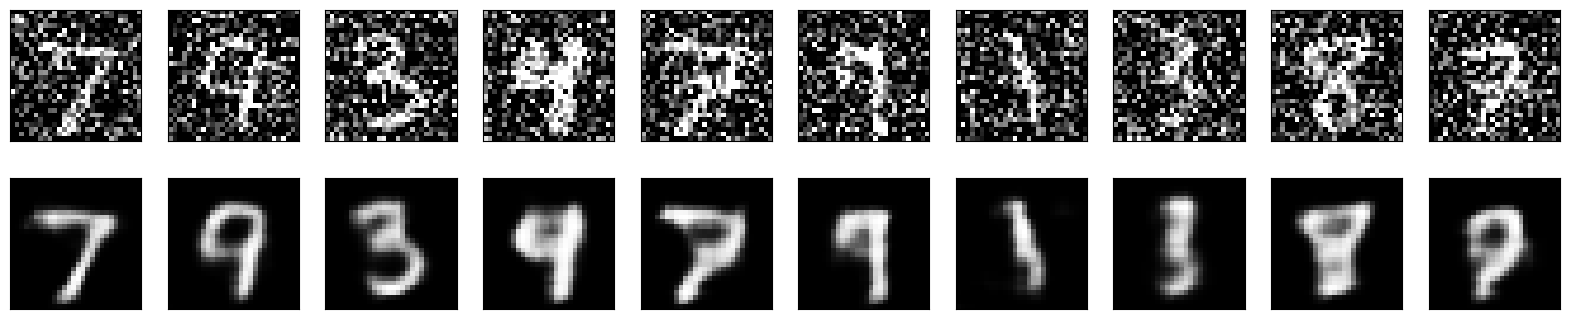

In [22]:
#decoded_imgs = ae_conv_decoder.predict(encoded_imgs)
dns_decoded_imgs = ae_conv_dns_decoder.predict(dns_encoded_imgs)
# dns_decoded_image = Ae_Conv_denoise.predict(x_test_noisy)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (dns_decoded_imgs.shape,
                                                                                                                      dns_encoded_imgs.shape))
n = 10  # how many digits we will display
k =16
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(dns_decoded_imgs[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 28, 28, 1)


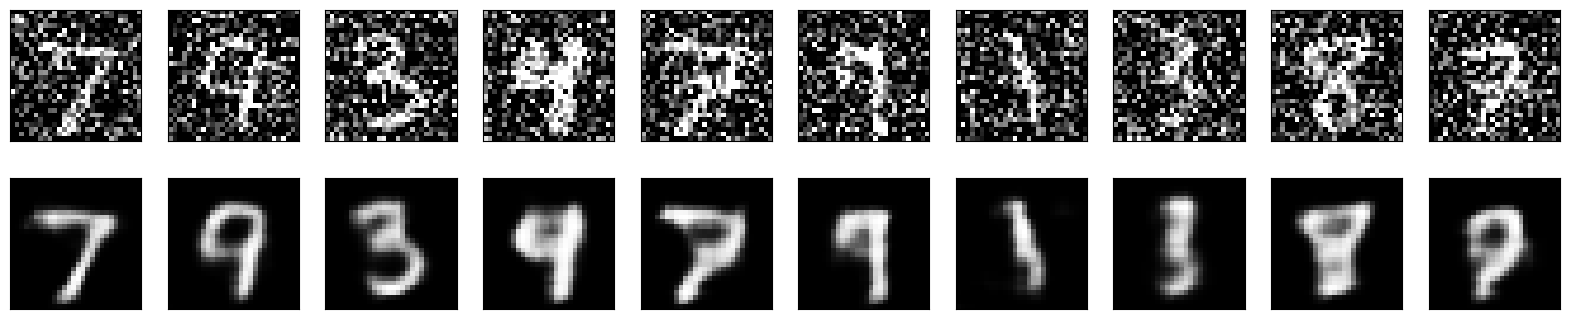

In [23]:
dns_decoded_image = Ae_Conv_denoise.predict(x_test_noisy)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (dns_decoded_image.shape,
                                                                                                                      dns_decoded_image.shape))
n = 10  # how many digits we will display
k =16
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(dns_decoded_image[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 28, 28, 1)


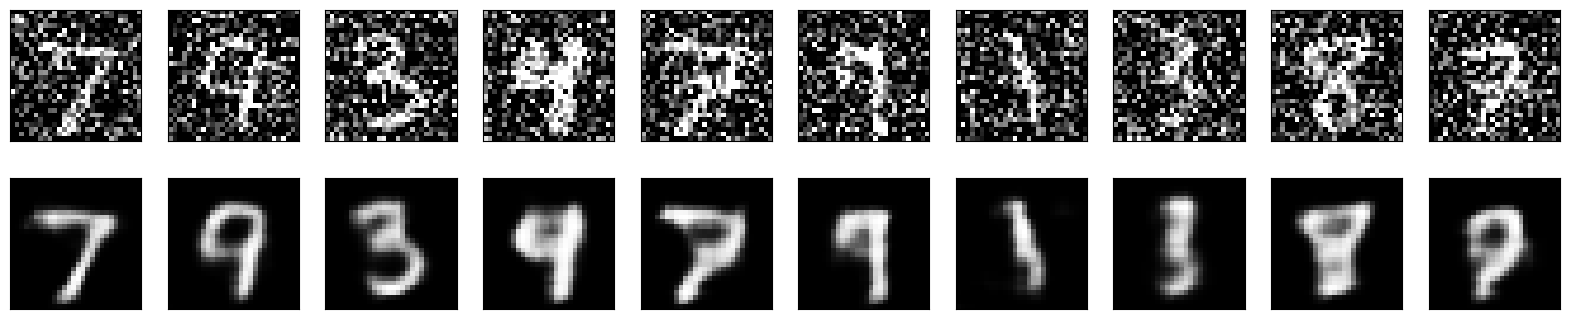

In [24]:
dns_decoded_image = Ae_Conv_denoise.predict(x_test_noisy)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (dns_decoded_image.shape,
                                                                                                                      dns_decoded_image.shape))
n = 10  # how many digits we will display
k =16
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(dns_decoded_image[i*k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()